In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout, BatchNormalization,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
#warnings.filterwarnings('ignore')

In [2]:
# Import dataset with Pandas 
URL="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"
dataset = pd.read_csv(URL, encoding="ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
dataset.describe(include="all")

print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

dataset.describe(include="all")

Number of rows : 5572

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
# Dropping useless columns
dataset= dataset.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)

In [5]:
# Let's have a look to the len of the dataset
len(dataset)

5572

In [6]:
# We rename our columns for a better understanding
dataset.rename(columns = {'v1':'type', 'v2': 'mail'}, inplace = True)

In [7]:
dataset.head()

,type,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# check count and unique and top values and their frequency
dataset['type'].value_counts()

ham     4825
spam     747
Name: type, dtype: int64

In [9]:
# target replaced by 1 or 0
dataset['type'] = dataset['type'].apply(lambda x:1 if x=='spam' else 0)

In [10]:
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-21 22:14:30.157623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-21 22:14:30.157699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-21 22:14:30.157712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [11]:
# Import Spacy and french initialisation
import en_core_web_md
nlp = en_core_web_md.load()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [12]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [13]:
# Make text preprocessing to clean the column "mail" and create a new column "mail_clean"
dataset["mail_clean"] = dataset["mail"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["mail_clean"] = dataset["mail_clean"].apply(lambda x: x.replace("å","").lower().strip())
dataset["mail_clean"] = dataset["mail_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

dataset

,type,mail,mail_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win 750 pound prize...
5568,0,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,0,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free


In [14]:
# We keep only the rows where mail clean malis not null 
mask = dataset["mail_clean"].isna()==False
dataset = dataset[mask]

In [15]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(dataset["mail_clean"]) # we apply our tokenizer to our column mail clean
dataset["mail_encoded"] = tokenizer.texts_to_sequences(dataset.mail_clean)
dataset["len_mail"] = dataset["mail_encoded"].apply(lambda x: len(x)) # we create a column len to display the len of our mail encoded
dataset = dataset[dataset["len_mail"]!=0] # we keep only not null values

In [16]:
mails_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.mail_encoded, padding="post") # padding 

In [17]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(mails_pad,dataset.type, test_size=0.3)

In [18]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)) 
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [19]:
train_batch = train.shuffle(len(train)).batch(64) # we create our batches of 64 and we shuffle it
val_batch = val.shuffle(len(val)).batch(64)

In [20]:
 # let's vizualise a batch
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[  7  78  42 ...   0   0   0]
 [  1 559   1 ...   0   0   0]
 [852 114 196 ...   0   0   0]
 ...
 [181   0   0 ...   0   0   0]
 [141  66 103 ...   0   0   0]
 [208   0   0 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0], shape=(64,), dtype=int64)


##Simple RNN

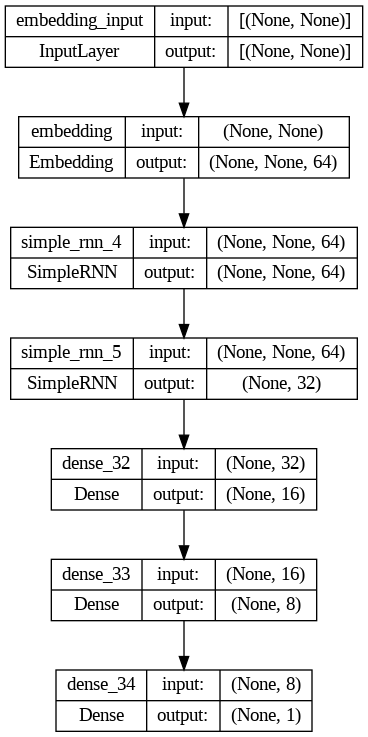

In [108]:
vocab_size = len(tokenizer.word_index) # We define our vocab size
model_RNN = tf.keras.Sequential([      
                  Embedding(vocab_size, 64,name="embedding"),# Word Embedding layer  
                  SimpleRNN(units=64, return_sequences=True), 
                  SimpleRNN(units=32, return_sequences=False), 
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])
tf.keras.utils.plot_model(model_RNN, show_shapes=True)

In [22]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          522880    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 534,913
Trainable params: 534,913
Non-trai

In [23]:
optimizer= tf.keras.optimizers.Adam()

model_RNN.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [24]:
#We intriduce the parameter class_weight because of our umbalanced dataset 
weights = 1/(dataset["type"]).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5801419965576592, 1: 3.619463087248322}

In [ ]:
# Model training 
history = model_RNN.fit(train_batch ,
                    epochs=100, 
                    validation_data=val_batch ,
                    class_weight=weights)

Epoch 1/100
59/59 [==============================] - 4s 34ms/step - loss: 0.4502 - binary_accuracy: 0.8564 - val_loss: 0.2292 - val_binary_accuracy: 0.9530
Epoch 2/100
59/59 [==============================] - 2s 30ms/step - loss: 0.2096 - binary_accuracy: 0.9528 - val_loss: 0.2235 - val_binary_accuracy: 0.9462
Epoch 3/100
59/59 [==============================] - 2s 41ms/step - loss: 0.1582 - binary_accuracy: 0.9581 - val_loss: 0.1744 - val_binary_accuracy: 0.9555
Epoch 4/100
59/59 [==============================] - 2s 30ms/step - loss: 0.1026 - binary_accuracy: 0.9809 - val_loss: 0.1613 - val_binary_accuracy: 0.9617
Epoch 5/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0860 - binary_accuracy: 0.9838 - val_loss: 0.2407 - val_binary_accuracy: 0.9302
Epoch 6/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0735 - binary_accuracy: 0.9865 - val_loss: 0.1794 - val_binary_accuracy: 0.9518
Epoch 7/100
59/59 [==============================] - 2s 30ms/ste

In [ ]:
model_RNN.save("model_simpleRNN.h5") # We save our model
json.dump(model_RNN.history.history, open("/content/simpleRNN_history.json", 'w')) # We save the results during epochs


In [ ]:
# We get from the saved file the history info in order to vizualise the loss and accuracy during epochs
tf.keras.utils.get_file("/content/model_simpleRNN.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_lstm_reg.h5")
tf.keras.utils.get_file("/content/simpleRNN_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_simpleRNN.json")
SimpleRNN_history = json.load(open("/content/simpleRNN_history.json", 'r'))
model_RNN = tf.keras.models.load_model("/content/model_simpleRNN.h5")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=SimpleRNN_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=SimpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


## LSTM

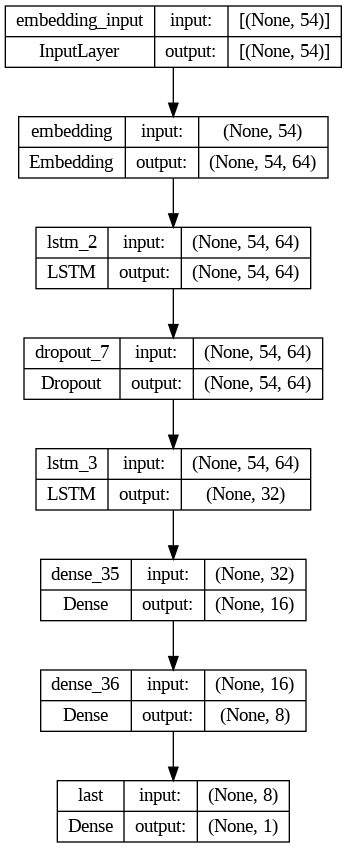

In [109]:
vocab_size = len(tokenizer.word_index) #definition of our vocab size
model_lstm = tf.keras.Sequential([ #creation of our lstm model
                  Embedding(vocab_size+1, 64, input_shape=[review.shape[1],],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  Dropout(0.2),
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid", name="last")
])
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

In [26]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 64)            522944    
                                                                 
 lstm (LSTM)                 (None, 54, 64)            33024     
                                                                 
 dropout (Dropout)           (None, 54, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 last (Dense)                (None, 1)                

In [27]:
optimizer= tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model_lstm.fit(train_batch,
              epochs=100, 
              validation_data=val_batch,
               class_weight=weights)

Epoch 1/100
59/59 [==============================] - 5s 93ms/step - loss: 0.6942 - binary_accuracy: 0.1399 - val_loss: 0.6957 - val_binary_accuracy: 0.1366
Epoch 2/100
59/59 [==============================] - 4s 74ms/step - loss: 0.6942 - binary_accuracy: 0.1399 - val_loss: 0.6960 - val_binary_accuracy: 0.1366
Epoch 3/100
59/59 [==============================] - 5s 81ms/step - loss: 0.6942 - binary_accuracy: 0.1399 - val_loss: 0.6965 - val_binary_accuracy: 0.1366
Epoch 4/100
59/59 [==============================] - 4s 69ms/step - loss: 0.6941 - binary_accuracy: 0.1399 - val_loss: 0.6959 - val_binary_accuracy: 0.1366
Epoch 5/100
59/59 [==============================] - 5s 79ms/step - loss: 0.6942 - binary_accuracy: 0.1399 - val_loss: 0.6948 - val_binary_accuracy: 0.1366
Epoch 6/100
59/59 [==============================] - 4s 70ms/step - loss: 0.6942 - binary_accuracy: 0.1399 - val_loss: 0.6960 - val_binary_accuracy: 0.1366
Epoch 7/100
59/59 [==============================] - 4s 70ms/ste

In [ ]:
# We get from the saved file the history info in order to vizualise the loss and accuracy during epochs
tf.keras.utils.get_file("/content/model_lstm.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_lstm_reg.h5")
tf.keras.utils.get_file("/content/LSTM_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/LSTM_history.json")
LSTM_history = json.load(open("/content/LSTM_history.json", 'r'))
model_lstm = tf.keras.models.load_model("/content/model_lstm.h5")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


LSTM does'nt give good results

## GRU

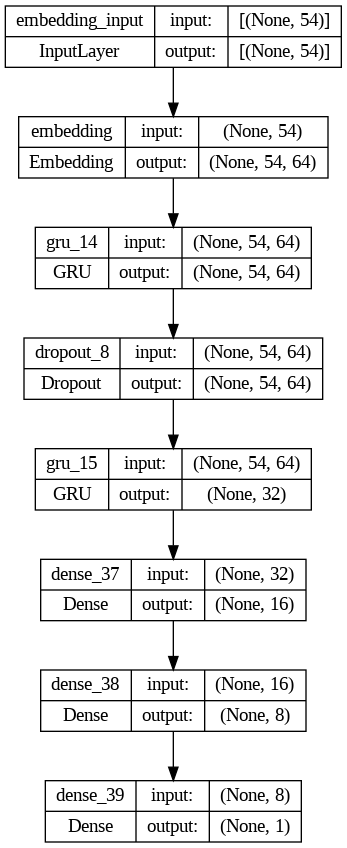

In [110]:
#We try GRU model
vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[review.shape[1],],name="embedding"),
                  #BatchNormalization(),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  Dropout(0.2),
                  #BatchNormalization(),
                  GRU(units=32, return_sequences=False), # returns the last output
                  #BatchNormalization(),
                  #Dropout(0.15),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])
tf.keras.utils.plot_model(model_gru, show_shapes=True)

In [90]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.4,
    staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [91]:
#optimizer= tf.keras.optimizers.Adam()
model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [92]:
model_gru.fit(train_batch,
              epochs=100, 
              validation_data=val_batch,class_weight=weights)

Epoch 1/10
59/59 [==============================] - 9s 90ms/step - loss: 0.6829 - binary_accuracy: 0.8668 - val_loss: 0.6801 - val_binary_accuracy: 0.8504
Epoch 2/10
59/59 [==============================] - 4s 62ms/step - loss: 0.6827 - binary_accuracy: 0.8654 - val_loss: 0.6803 - val_binary_accuracy: 0.8504
Epoch 3/10
59/59 [==============================] - 4s 73ms/step - loss: 0.6828 - binary_accuracy: 0.8657 - val_loss: 0.6798 - val_binary_accuracy: 0.8504
Epoch 4/10
59/59 [==============================] - 4s 64ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6808 - val_binary_accuracy: 0.8504
Epoch 5/10
59/59 [==============================] - 4s 65ms/step - loss: 0.6828 - binary_accuracy: 0.8665 - val_loss: 0.6801 - val_binary_accuracy: 0.8504
Epoch 6/10
59/59 [==============================] - 4s 69ms/step - loss: 0.6828 - binary_accuracy: 0.8665 - val_loss: 0.6795 - val_binary_accuracy: 0.8504
Epoch 7/10
59/59 [==============================] - 4s 64ms/step - los

In [93]:
model_gru.save("model_gru.h5")
json.dump(model_gru.history.history, open("/content/GRU_history.json", 'w'))

In [94]:
tf.keras.utils.get_file("/content/model_gru.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_gru.h5")
tf.keras.utils.get_file("/content/GRU_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/GRU_history.json")
GRU_history = json.load(open("/content/GRU_history.json", 'r'))
model_gru = tf.keras.models.load_model("/content/model_gru.h5")

In [95]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["binary_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=GRU_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.show()

# Model creation with embedding layers

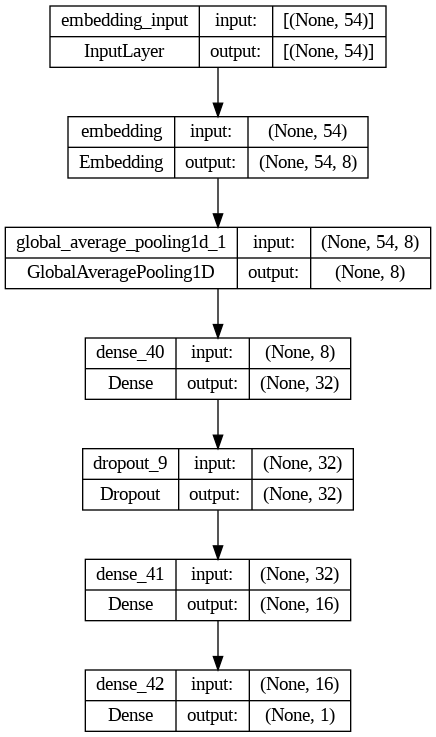

In [124]:
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)



In [125]:

optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])



In [126]:
# visualization of the model
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65368     
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_40 (Dense)            (None, 32)                288       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                     

In [127]:
# train model
model.fit(train_batch, 
            epochs=20, 
            validation_data=val_batch,
            class_weight=weights)

Epoch 1/20
59/59 [==============================] - 1s 4ms/step - loss: 0.6788 - binary_accuracy: 0.8668 - val_loss: 0.6505 - val_binary_accuracy: 0.8504
Epoch 2/20
59/59 [==============================] - 0s 3ms/step - loss: 0.6583 - binary_accuracy: 0.8795 - val_loss: 0.5570 - val_binary_accuracy: 0.8603
Epoch 3/20
59/59 [==============================] - 0s 4ms/step - loss: 0.5861 - binary_accuracy: 0.9184 - val_loss: 0.4043 - val_binary_accuracy: 0.9382
Epoch 4/20
59/59 [==============================] - 0s 4ms/step - loss: 0.4644 - binary_accuracy: 0.9626 - val_loss: 0.2468 - val_binary_accuracy: 0.9629
Epoch 5/20
59/59 [==============================] - 0s 3ms/step - loss: 0.3260 - binary_accuracy: 0.9783 - val_loss: 0.1470 - val_binary_accuracy: 0.9710
Epoch 6/20
59/59 [==============================] - 0s 4ms/step - loss: 0.2094 - binary_accuracy: 0.9788 - val_loss: 0.1058 - val_binary_accuracy: 0.9759
Epoch 7/20
59/59 [==============================] - 0s 4ms/step - loss: 0.15

In [128]:
model_gru.save("model.h5")
json.dump(model.history.history, open("/content/model_history.json", 'w'))

In [129]:
tf.keras.utils.get_file("/content/model.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model.h5")
tf.keras.utils.get_file("/content/model_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_history.json")
model_history = json.load(open("/content/model_history.json", 'r'))
model = tf.keras.models.load_model("/content/model.h5")

In [130]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [131]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_history["binary_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=model_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.show()